<a href="https://colab.research.google.com/github/Freddy-94/PSO_Implementation/blob/main/Swarm_intelligence_PSO_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alfredo Bernal Luna
### Practice No. 4. Swarm intelligence - PSO algorithm.

# Modules to be used in this program:

In [ ]:
import numpy as np                      # for Acleys plot
from numpy import sqrt, cos, e, pi, exp # for Ackley's function plot
import random                           # for randoms
import matplotlib.pyplot as plt         # to plot

# Definition of cost function:

1. Ackley's function.

   Let $f : {[-32.768, 32.768]} ^n \to \mathbb{R}$ given by:

  \begin{align}
          f(\mathbf{x}) = -20\mathrm{e}^{-0.2\sqrt{1/n\sum_{i=1}^n x_{i}^{2}}} - \mathrm{e}^{1/n\sum_{i=1}^n \cos {2\pi x_{i}}} + 20 + \mathrm{e}
  \end{align}

In [ ]:
def ackley(n, x): 
    gen_cos_avg = 0
    root_mean_square = 0
    for i in range(0, n):
        gen_cos_avg += cos(2*pi*x[i])
        root_mean_square += x[i]**2
    root_mean_square = sqrt((1/n)*(root_mean_square))         
    ackley = -20*exp((-0.2)*(root_mean_square)) - exp(gen_cos_avg) +  20 + e
    return ackley

# Test of the cost functions (dimension = 10):

In [ ]:
ackley(10, [31.0261, -31.6548, -21.265, 20.264, 10.00156, -20.0165, -30.1235, 20.0326, 10.698, 10.145])

-45.61924996821731

# Graph of Ackley's function in 3D:

In [ ]:
def plot_cost_function_3d(vars_domain, num_points_to_plot, cost_fun):
    """
    Function to plot the graphs of the cost functions, in 3 dimensions. This function might be 
    useful to gain more intuition on the problem at hand
    """
    x1 = np.linspace(vars_domain[0], vars_domain[1], num_points_to_plot)
    x2 = x1
    coord_array_x1, coord_array_x2 = np.meshgrid(x1, x2)
    cost = cost_fun(2, [coord_array_x1, coord_array_x2]) 
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    ax.plot_surface(coord_array_x1, coord_array_x2, cost, rstride = 1, cstride = 1,
                    cmap = 'viridis', edgecolor = 'none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

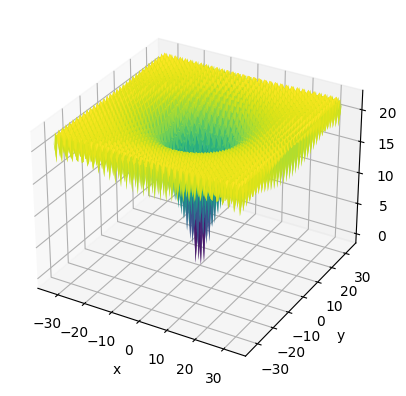

In [ ]:
plot_cost_function_3d([-32.768, 32.768], 100, ackley)

# Class particle to model a particle object

In [ ]:
class Particle:
    def __init__(self):
        """
        Atributes needed to model a particle
        """ 
        self.lower_bounds = []
        self.upper_bounds = []
        self.position = []
        self.velocity = []
        self.historic_fitnesses = []
    
    def store_fitnesses(self, particle_trace):
        """
        Mutator method for setting the fitness of the particle
        """  
        self.historic_fitnesses.append(particle_trace)
    
    def find_pBest(self, max_min):
        """
        Method for returning the pBest of the particle
        """
        if max_min == "max":
            pBest = max(self.historic_fitnesses, key = lambda x: x[1])
        else:
            pBest = min(self.historic_fitnesses, key = lambda x: x[1])
        return pBest

    def set_lower_bounds(self, dom_low_bounds):
        """
        Mutator method for setting the low boundaries where the cost function is
        defined; i.e., if the domain of the cost function is:
        [a1, b1] x [a2, b2] x ... x [a_n, b_n]
        then, the dow_low_bounds = [a1, a2, ..., a_n]
        """ 
        self.lower_bounds = dom_low_bounds

    def set_upper_bounds(self, dom_upper_bounds):
        """
        Mutator method for setting the upper boundaries where the cost function is
        defined; i.e., if the domain of the cost function is:
        [a1, b1] x [a2, b2] x ... x [a_n, b_n]
        then, the dow_upper_bounds = [b1, b2, ..., b_n]
        """ 
        self.upper_bounds = dom_upper_bounds 

    def set_random_initial_position(self):
        """
        Mutator method for setting the initial random position that the particle
        will have
        """
        for i in range(len(self.lower_bounds)):
            self.position.append(round(random.uniform(self.lower_bounds[i], self.upper_bounds[i]), 5))

    def set_random_initial_velocity(self):
        """
        Mutator method for setting the initial random velocity that the particle
        will have
        """
        for i in range(len(self.lower_bounds)):
            self.velocity.append(round(random.uniform(self.lower_bounds[i], self.upper_bounds[i]), 5))                     

    def update_velocity(self, w, c1, pBest, c2, gBest):
        """
        Mutator method for updating the current velocity of the particle
        """    
        for i in range(len(self.velocity)):
            r1 = random.uniform(0, 1)
            r2 = random.uniform(0, 1)
            self.velocity[i] = (w * self.velocity[i]) + (c1 * r1) * (pBest[i] - self.position[i]) + (c2 * r2) * (gBest[i] - self.position[i])
        
    def update_position(self):
        """
        Mutator method for updating the current position of the particle
        """
        for i in range(len(self.position)):
            self.position[i] += self.velocity[i]

    def validate_bounds(self):
        """
        For not jumping outside of the domain of the cost function.
        We're considering functions with domain of the form:
        [a1, b1] x [a2, b2] x ... x [a_n, b_n]
        """  
        for i in range(len(self.position)):
            if self.position[i] < self.lower_bounds[i] or self.position[i] > self.upper_bounds[i]:
                self.position[i] = random.uniform(self.lower_bounds[i], self.upper_bounds[i])
    

# Class list to model the swarm particles

In [ ]:
class Swarm:
    def __init__(self):
        self.particles = []
    
    def append(self, particle):
        self.particles += [particle]
        
    def __len__(self):
        return len(self.particles)
        
    def removeLast(self):
        return self.particles.pop()

    """    
    if we want to iterate over this sequence, we define the special method
    called __iter__(self).
    Without this we'll get "builtins.TypeError:
    'Swarm' object is not iterable", if we try to write for cmd in seq,
    where seq is one of these sequences.
    The yield below will yield an element of the sequence and will suspend
    the execution of the for loop in the method below until the next element is
    needed. The ability to yield each element of the sequence as needed is called
    "lazy" evaluation and is very powerful. It means that we only need to provide
    access to as many of elements of the sequence as are necessary and no more.
    """
    def __iter__(self):
        for p in self.particles:
            yield p     

# Initialize random swarm 

In [ ]:
def initialize_swarm(size, lower_bounds, upper_bounds):
    swarm = Swarm()
    for i in range(size):
        p = Particle()
        p.set_lower_bounds(lower_bounds)
        p.set_upper_bounds(upper_bounds)
        p.set_random_initial_position()
        p.set_random_initial_velocity()
        swarm.append(p)
    return swarm

# Unit test for the correct initialization of a random swarm in 3-D 

In [ ]:
init_swarm = initialize_swarm(5, [-32.768, -32.768, -32.768], [32.768, 32.768, 32.768]) 
print(f"Particles position vectors\t\t\tParticles velocity vectors")
print("=======================================================================================")
for particle in init_swarm:
    print(f"{particle.position}\t\t\t{particle.velocity}")

Particles position vectors			Particles velocity vectors
[-6.47865, 17.8051, -25.30964]			[-9.77765, -26.15392, 2.01458]
[-3.02107, 31.03078, -9.65254]			[12.49134, 12.24626, 25.80151]
[12.61535, 6.66158, -22.75832]			[8.38912, -31.27563, 31.33689]
[-30.13135, 18.24576, 28.95542]			[-20.70067, -1.04877, 32.74459]
[14.91914, 28.37122, 4.95818]			[5.32038, -26.12078, 5.9402]


# Swarm evaluation 

In [ ]:
def swarm_eval(swarm, cost_fun):
    fitness_list = []
    for particle in swarm:
        dim = len(particle.lower_bounds)
        particle_fitness = round(cost_fun(dim, particle.position), 5)
        particle_trace = [particle.position, particle_fitness]
        particle.store_fitnesses(particle_trace)
        fitness_list.append(particle_trace)
    return fitness_list

# Unit test for the correct evaluation of swarm values, in 3-D 

In [ ]:
swarm_fitness = swarm_eval(init_swarm, ackley)
print(swarm_fitness)

[[[-6.47865, 17.8051, -25.30964], 21.8374], [[-3.02107, 31.03078, -9.65254], 18.2103], [[12.61535, 6.66158, -22.75832], 21.52458], [[-30.13135, 18.24576, 28.95542], 17.32394], [[14.91914, 28.37122, 4.95818], 19.08992]]


# Obtain the gBest of the swarm

In [ ]:
def find_gBest(swarm_fitness, max_min):
    if max_min == "max":
        gBest = max(swarm_fitness, key = lambda x: x[1])
    else:
        gBest = min(swarm_fitness, key = lambda x: x[1])
    return gBest

# Unit test for the correct search of the gBest of the swarm. Notice that since we're considering the Ackley's function, we want to minimize! 

In [ ]:
gBest = find_gBest(swarm_fitness, "min")
print(gBest)

[[-30.13135, 18.24576, 28.95542], 17.32394]


# Integration of the PSO algorithm

In [ ]:
def pso_algo(w, c1, c2, size, lower_bounds, upper_bounds, cost_fun, max_min, max_iters):
    swarm = initialize_swarm(size, lower_bounds, upper_bounds)
    swar_fitnesses = swarm_eval(swarm, cost_fun)
    gBest = find_gBest(swar_fitnesses, max_min)
    iters = 0
    while iters < max_iters:
        for particle in swarm:
            particle_pBest = particle.find_pBest(max_min)[0]   
            particle.update_velocity(w, c1, particle_pBest, c2, gBest[0])
            particle.update_position()
            particle.validate_bounds()
        swar_fitnesses = swarm_eval(swarm, cost_fun)
        newgBest = find_gBest(swar_fitnesses, max_min)
        if max_min == "max":
            if newgBest[1] > gBest[1]:
                gBest = newgBest
        else:
            if gBest[1] > newgBest[1]:
                gBest = newgBest             
        iters += 1
    return gBest    

# Main function to call the PSO algorithm

## Config 1.

In [ ]:
def config1():
    w = 0.5
    c1 = 0.0
    c2 =  0.5
    swarm_size = 50
    dim = 10
    lower_bounds = dim * [-32.768] 
    upper_bounds = dim * [32.768]
    max_min = "min"
    max_iters = 10000
    best_sol = pso_algo(w, c1, c2, swarm_size, lower_bounds, upper_bounds, ackley, max_min, max_iters)
    print(f"Best particle: {best_sol[0]} has a fitness of: {best_sol[1]}")

## Config 2.

In [ ]:
def config2():
    w = 0.5
    c1 = 0.0
    c2 =  2.0
    swarm_size = 50
    dim = 10
    lower_bounds = dim * [-32.768] 
    upper_bounds = dim * [32.768]
    max_min = "min"
    max_iters = 10000
    best_sol = pso_algo(w, c1, c2, swarm_size, lower_bounds, upper_bounds, ackley, max_min, max_iters)
    print(f"Best particle: {best_sol[0]} has a fitness of: {best_sol[1]}")

## Config 3.

In [ ]:
def config3():
    w = 0.5
    c1 = 0.5
    c2 =  0.0
    swarm_size = 50
    dim = 10
    lower_bounds = dim * [-32.768] 
    upper_bounds = dim * [32.768]
    max_min = "min"
    max_iters = 10000
    best_sol = pso_algo(w, c1, c2, swarm_size, lower_bounds, upper_bounds, ackley, max_min, max_iters)
    print(f"Best particle: {best_sol[0]} has a fitness of: {best_sol[1]}")

## Config 4.

In [ ]:
def config4():
    w = 0.5
    c1 = 2.0
    c2 =  0.0
    swarm_size = 50
    dim = 10
    lower_bounds = dim * [-32.768] 
    upper_bounds = dim * [32.768]
    max_min = "min"
    max_iters = 10000
    best_sol = pso_algo(w, c1, c2, swarm_size, lower_bounds, upper_bounds, ackley, max_min, max_iters)
    print(f"Best particle: {best_sol[0]} has a fitness of: {best_sol[1]}")

## Config 5.

In [ ]:
def config5():
    w = 0.5
    c1 = 0.5
    c2 =  2.0
    swarm_size = 50
    dim = 10
    lower_bounds = dim * [-32.768] 
    upper_bounds = dim * [32.768]
    max_min = "min"
    max_iters = 10000
    best_sol = pso_algo(w, c1, c2, swarm_size, lower_bounds, upper_bounds, ackley, max_min, max_iters)
    print(f"Best particle: {best_sol[0]} has a fitness of: {best_sol[1]}")

## Config 6.

In [ ]:
def config6():
    w = 0.5
    c1 = 2.0
    c2 =  0.5
    swarm_size = 50
    dim = 10
    lower_bounds = dim * [-32.768] 
    upper_bounds = dim * [32.768]
    max_min = "min"
    max_iters = 10000
    best_sol = pso_algo(w, c1, c2, swarm_size, lower_bounds, upper_bounds, ackley, max_min, max_iters)
    print(f"Best particle: {best_sol[0]} has a fitness of: {best_sol[1]}")

## Config 7.

In [ ]:
def config7():
    w = 1
    c1 = 0.0
    c2 =  0.5
    swarm_size = 50
    dim = 10
    lower_bounds = dim * [-32.768] 
    upper_bounds = dim * [32.768]
    max_min = "min"
    max_iters = 10000
    best_sol = pso_algo(w, c1, c2, swarm_size, lower_bounds, upper_bounds, ackley, max_min, max_iters)
    print(f"Best particle: {best_sol[0]} has a fitness of: {best_sol[1]}")

## Config 8.

In [ ]:
def config8():
    w = 1.0
    c1 = 0.0
    c2 =  2.0
    swarm_size = 50
    dim = 10
    lower_bounds = dim * [-32.768] 
    upper_bounds = dim * [32.768]
    max_min = "min"
    max_iters = 10000
    best_sol = pso_algo(w, c1, c2, swarm_size, lower_bounds, upper_bounds, ackley, max_min, max_iters)
    print(f"Best particle: {best_sol[0]} has a fitness of: {best_sol[1]}")

## Config 9.

In [ ]:
def config9():
    w = 1.0
    c1 = 0.5
    c2 =  0.0
    swarm_size = 50
    dim = 10
    lower_bounds = dim * [-32.768] 
    upper_bounds = dim * [32.768]
    max_min = "min"
    max_iters = 10000
    best_sol = pso_algo(w, c1, c2, swarm_size, lower_bounds, upper_bounds, ackley, max_min, max_iters)
    print(f"Best particle: {best_sol[0]} has a fitness of: {best_sol[1]}")

## Config 10.

In [ ]:
def config10():
    w = 1.0
    c1 = 2.0
    c2 =  0.0
    swarm_size = 50
    dim = 10
    lower_bounds = dim * [-32.768] 
    upper_bounds = dim * [32.768]
    max_min = "min"
    max_iters = 10000
    best_sol = pso_algo(w, c1, c2, swarm_size, lower_bounds, upper_bounds, ackley, max_min, max_iters)
    print(f"Best particle: {best_sol[0]} has a fitness of: {best_sol[1]}")

## Config 11.

In [ ]:
def config11():
    w = 1.0
    c1 = 0.5
    c2 =  2.0
    swarm_size = 50
    dim = 10
    lower_bounds = dim * [-32.768] 
    upper_bounds = dim * [32.768]
    max_min = "min"
    max_iters = 10000
    best_sol = pso_algo(w, c1, c2, swarm_size, lower_bounds, upper_bounds, ackley, max_min, max_iters)
    print(f"Best particle: {best_sol[0]} has a fitness of: {best_sol[1]}")

## Config 12.

In [ ]:
def config12():
    w = 1.0
    c1 = 2.0
    c2 =  0.5
    swarm_size = 50
    dim = 10
    lower_bounds = dim * [-32.768] 
    upper_bounds = dim * [32.768]
    max_min = "min"
    max_iters = 10000
    best_sol = pso_algo(w, c1, c2, swarm_size, lower_bounds, upper_bounds, ackley, max_min, max_iters)
    print(f"Best particle: {best_sol[0]} has a fitness of: {best_sol[1]}")

In [ ]:
def main():
    for i in range(20):
        config1()
        config2()
        config3()
        config4()
        config5()
        config6()
        config7()
        config8()
        config9()
        config10()
        config11()
        config12()    

if __name__ == '__main__':
    main()

IndentationError: ignored